In [1]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
!python -V

Python 3.12.3


##### Q1

In [2]:
url_jan_2023 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
url_feb_2023 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

df_jan = pd.read_parquet(url_jan_2023)

print(f"Number of columns in df_jan: {len(df_jan.columns)}")

selected_cols = ['tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'PULocationID',
    'DOLocationID',
    'passenger_count',
    'trip_distance',
    'total_amount'
    ]


Number of columns in df_jan: 19


##### Q2, Q3

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99.9%    1.758215e+02
max      1.002918e+04
Name: duration, dtype: float64
Records left: 98.1220282212598%


<Axes: xlabel='duration', ylabel='Count'>

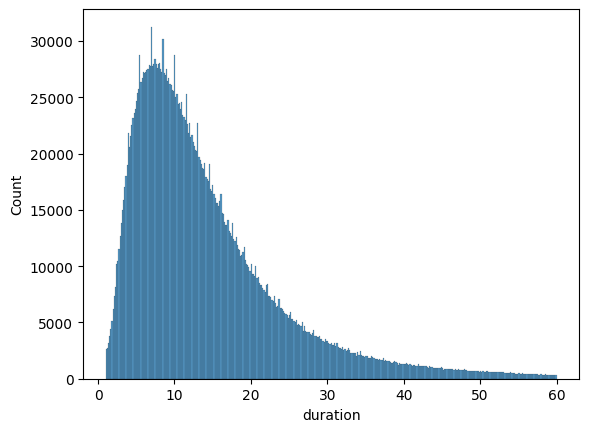

In [4]:
df = df_jan[selected_cols].copy()
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
print(df.duration.describe(percentiles=[0.95, 0.98, 0.999]))
original_jan_size = len(df)
df = df[(df.duration <= 60) & (df.duration >= 1)]
records_left = len(df)*100/original_jan_size
print(f"Records left: {records_left}%")
sns.histplot(df.duration, label='duration')


##### Q4

In [3]:
df = df_jan[selected_cols].copy()
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
df = df[(df.duration <= 60) & (df.duration >= 1)]
cat = ['PULocationID', 'DOLocationID']
df = df[cat + ['duration']]
df[cat] = df[cat].astype(str)
dv = DictVectorizer()
dict_list = df[cat].to_dict(orient='records')
X = dv.fit_transform(dict_list)
print(f"Feature matrix columns: {X.shape[1]}")
del df, df_jan, X, dv


Feature matrix columns: 515


##### Q5

In [4]:
def read_process_data(filename: str, feature_cols: list, target: str) -> pd.DataFrame:
    df = pd.read_parquet(filename)
    df[target] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
    df = df[(df.duration <= 60) & (df.duration >= 1)]
    df = df[feature_cols + [target]]
    df[feature_cols] = df[feature_cols].astype(str)

    return df

# load & processing
feature_cols = ['PULocationID', 'DOLocationID']
target = 'duration'
df_train = read_process_data(
    filename = url_jan_2023,
    feature_cols = feature_cols,
    target = target
    )
dv = DictVectorizer()
train_dicts = df_train[feature_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values

# training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

# eval
print(f"RMSE: {root_mean_squared_error(y_train, y_pred)}")

del df_train, y_train, train_dicts



RMSE: 7.6492624397080675


##### Q6

In [5]:
# load & processing
df_val = read_process_data(
    filename = url_feb_2023,
    feature_cols = feature_cols,
    target = target
    )

val_dicts = df_val[feature_cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

y_pred_val = lr.predict(X_val)
print(f'RMSE val: {root_mean_squared_error(y_val, y_pred_val)}')

RMSE val: 7.81181211389241
